
# **Initiate Spark**

In [ ]:
# Using ! to execute a command in the command line or terminal
# Using pip3 to interact with the Python package manager for Python 3.x
# Using install to specify that we want to install a package
# Install the PySpark library, which is the Python API for Apache Spark


!pip3 install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=9504ced3ee6ebee85e076c01f8a5a3d356d6dd8ff0c87e04c2e9b08f115bcd14
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark



# **Connect Google Drive**

In [ ]:
# Importing the 'drive' module from the 'google.colab' library to mount Google Drive
from google.colab import drive

# Mounting the Google Drive at the '/content/drive' directory
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing the SparkSession class from the pyspark.sql module
from pyspark.sql import SparkSession

# Creating a SparkSession named 'spark' to interact with Spark
# The 'master' parameter is set to "local[*]", which means Spark will run in local mode using all available cores
# The 'appName' parameter is set to 'Fraud Detection' to give a name to the Spark application
# The 'getOrCreate()' method ensures that if an existing SparkSession is available, it will be reused; otherwise, a new one will be created


spark = SparkSession.builder \
        .master("local[*]") \
        .appName('Fraud Detection') \
        .config("spark.driver.memory", "8g") \
        .config("spark.kryoserializer.buffer.max", "1g") \
        .getOrCreate()

---
# **Data Loading and Preprocessing**
---

In [ ]:
# load spark_df using spark
spark_df = spark.read.csv('/content/drive/MyDrive/big_data/transactions_train.csv',inferSchema=True, header =True)

# available columns in this spark_df
spark_df.columns

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrig',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud']

In [ ]:
spark_df.describe().show()

+-------+------------------+--------+-----------------+-----------+-----------------+------------------+-----------+------------------+------------------+--------------------+
|summary|              step|    type|           amount|   nameOrig|   oldbalanceOrig|    newbalanceOrig|   nameDest|    oldbalanceDest|    newbalanceDest|             isFraud|
+-------+------------------+--------+-----------------+-----------+-----------------+------------------+-----------+------------------+------------------+--------------------+
|  count|           6351193| 6351193|          6351193|    6351193|          6351193|           6351193|    6351193|           6351193|           6351193|             6351193|
|   mean|242.55529819358347|    NULL|179815.5359635669|       NULL|834795.6840371998|  856169.582831443|       NULL|1101042.5969942801|1225371.9736932502|0.001215047314732...|
| stddev|141.06763627792867|    NULL|603630.9774416926|       NULL|2889959.094210148|2926073.0596211716|       NULL|3398

In [ ]:
from pyspark.sql.functions import isnan, when, count, col

# Check for missing values in each column
missing_counts = spark_df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in spark_df.columns])
missing_counts.show()

# Check for missing values in any row
total_missing_count = spark_df.rdd.map(lambda row: sum([1 for x in row if x == None])).sum()
print("Total missing values in DataFrame: {}".format(total_missing_count))

+----+----+------+--------+--------------+--------------+--------+--------------+--------------+-------+
|step|type|amount|nameOrig|oldbalanceOrig|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|
+----+----+------+--------+--------------+--------------+--------+--------------+--------------+-------+
|   0|   0|     0|       0|             0|             0|       0|             0|             0|      0|
+----+----+------+--------+--------------+--------------+--------+--------------+--------------+-------+

Total missing values in DataFrame: 0


In [ ]:
# check the type of features
spark_df.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrig: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)



In [ ]:
from pyspark.ml.feature import StringIndexer

# convert all the string features into numerical values
input_features=["type", "nameOrig", "nameDest"]

for ch in input_features:
    l_indexer = StringIndexer(inputCol=ch, outputCol=ch+"_numeric")
    spark_df = l_indexer.fit(spark_df).transform(spark_df)
spark_df = spark_df.drop(*input_features)

spark_df.show()

+----+---------+--------------+--------------+--------------+--------------+-------+------------+----------------+----------------+
|step|   amount|oldbalanceOrig|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|type_numeric|nameOrig_numeric|nameDest_numeric|
+----+---------+--------------+--------------+--------------+--------------+-------+------------+----------------+----------------+
|   1|  9839.64|      170136.0|     160296.36|           0.0|           0.0|      0|         0.0|          9486.0|         26437.0|
|   1|  1864.28|       21249.0|      19384.72|           0.0|           0.0|      0|         0.0|         27491.0|         27503.0|
|   1|    181.0|         181.0|           0.0|           0.0|           0.0|      1|         3.0|         12512.0|          2552.0|
|   1|    181.0|         181.0|           0.0|       21182.0|           0.0|      1|         1.0|         73362.0|          4022.0|
|   1| 11668.14|       41554.0|      29885.86|           0.0|           0.0|



# Combine all the features in one single feature vector
Various methods exist for creating a single feature vector, however we choose to utilize the vector assembler methodology.
The VectorAssembler supports input column types such as all numeric kinds, boolean type, and vector type2. PySpark relies heavily on this program for data preparation, particularly when working with extensive datasets


In [ ]:
#combine all the features in one single feature vector.
from pyspark.ml.feature import VectorAssembler

cols=spark_df.columns
cols.remove("isFraud")
assembler = VectorAssembler(inputCols=cols,outputCol="features")

# Use the transform method to transform spark_df
spark_df=assembler.transform(spark_df)
spark_df.select("features").show(truncate=False)

+-----------------------------------------------------------------+
|features                                                         |
+-----------------------------------------------------------------+
|[1.0,9839.64,170136.0,160296.36,0.0,0.0,0.0,9486.0,26437.0]      |
|[1.0,1864.28,21249.0,19384.72,0.0,0.0,0.0,27491.0,27503.0]       |
|[1.0,181.0,181.0,0.0,0.0,0.0,3.0,12512.0,2552.0]                 |
|[1.0,181.0,181.0,0.0,21182.0,0.0,1.0,73362.0,4022.0]             |
|[1.0,11668.14,41554.0,29885.86,0.0,0.0,0.0,43228.0,13926.0]      |
|[1.0,7817.71,53860.0,46042.29,0.0,0.0,0.0,75834.0,35181.0]       |
|[1.0,7107.77,183195.0,176087.23,0.0,0.0,0.0,22661.0,32435.0]     |
|[1.0,7861.64,176087.23,168225.59,0.0,0.0,0.0,37587.0,36186.0]    |
|[1.0,4024.36,2671.0,0.0,0.0,0.0,0.0,10856.0,13085.0]             |
|[1.0,5337.77,41720.0,36382.23,41898.0,40348.79,4.0,67925.0,283.0]|
|[1.0,9644.94,4465.0,0.0,10845.0,157982.12,4.0,37055.0,70.0]      |
|[1.0,3099.97,20771.0,17671.03,0.0,0.0,0.0,48755

#  Advanced Data Analysis and Exploraton

Upon conducting more data analysis and research, we have discovered that our data exhibits an imbalance. Specifically, the fraudulent instances account for 0.1% of the data, while the non-fraudulent instances make up 99.9%. The distribution is visually shown in the pie chart below.


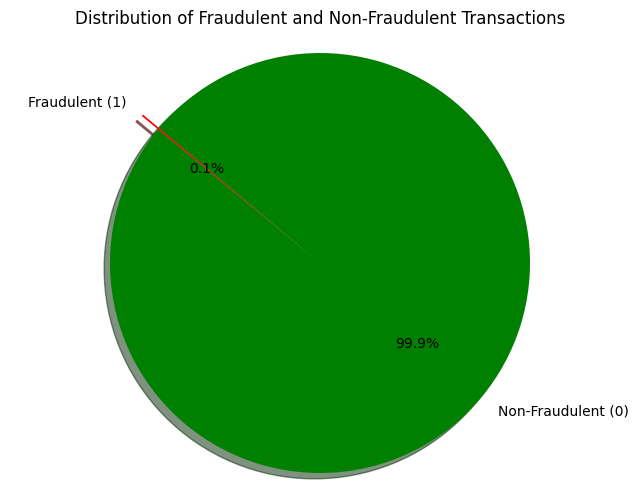

In [ ]:
#imbalance in the dataset
import matplotlib.pyplot as plt

# Calculate counts of 1s and 0s from dataframe
num_ones = spark_df.where(spark_df["isFraud"] == 1).count()
num_zeros = spark_df.where(spark_df["isFraud"] == 0).count()

labels = 'Fraudulent (1)', 'Non-Fraudulent (0)'
sizes = [num_ones, num_zeros]
colors = ['red', 'green']
explode = (0.1, 0)  # explode 1st slice (fraudulent)

# Plot
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Distribution of Fraudulent and Non-Fraudulent Transactions')
plt.show()


Class imbalance is a prevalent problem in machine learning, particularly in classification tasks, when the classes are not evenly represented. This indicates that the training dataset does not include an equal number of examples for each class label, resulting in an imbalance. In a binary classification issue, the majority of the instances are likely to belong to one class, whereas the other class only has a small number of cases.

# **Class Imbalance Mitigation: Undersampling**

There are different options available to remedy class imbalance, and in this situation, we have selected for the under-sampling approach within the category of resampling techniques.Undersampling is a procedure used in data preparation, specifically when dealing with imbalanced datasets. It aims to equalize the class distribution by decreasing the size of the majority class (the class with more instances) to match the size of the minority class (the class with fewer instances).Below we have ploted the pie chart after conducting undersampling for imbalance dataset


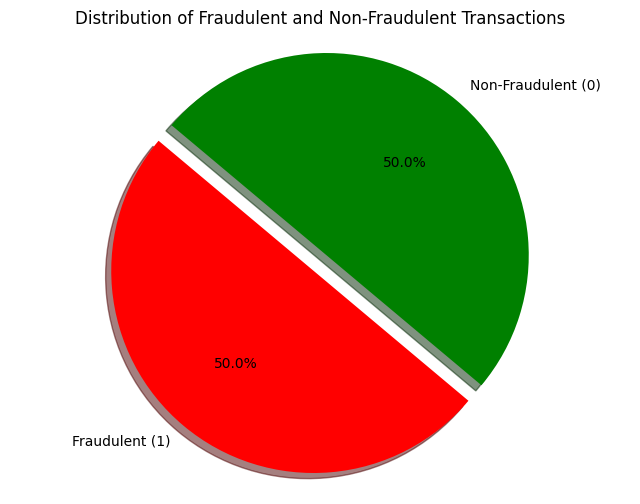

In [ ]:
# minimum count between the two classes
minimum_count = min(num_ones, num_zeros)

# Undersample the majority class
undersampled_df = spark_df.where(spark_df["isFraud"] == 0).sample(False, fraction=minimum_count / num_zeros, seed=42)

# get df to include all rows with label 1
ones_df = spark_df.where(spark_df["isFraud"] == 1)

# Combine the undersampled DataFrame with ones_df to get a balanced_df
balanced_df = ones_df.union(undersampled_df)


# Calculate counts of 1s and 0s from dataframe
new_num_ones = balanced_df.where(balanced_df["isFraud"] == 1).count()
new_num_zeros = balanced_df.where(balanced_df["isFraud"] == 0).count()

labels = 'Fraudulent (1)', 'Non-Fraudulent (0)'
sizes = [new_num_ones, new_num_zeros]
colors = ['red', 'green']
explode = (0.1, 0)

# Plot
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Distribution of Fraudulent and Non-Fraudulent Transactions')
plt.show()

# **Splitting the Dataset into Training and Testing Sets**

In [ ]:
# Split into train and test
train, test = balanced_df.randomSplit([0.8, 0.2], seed=47)

Standard Scalarizer-This strategy is particularly beneficial since many machine learning algorithms perform better when their input variables are scaled to a standard range. This covers algorithms that employ a weighted sum of the input, like linear regression, and algorithms that use distance measurements, such k-nearest neighbors


In [ ]:
# Standard Sclarizer
# Standard scaling transforms the features to have a mean of 0 and a standard deviation of 1
from pyspark.ml.feature import StandardScaler

standardscaler = StandardScaler(inputCol="features", outputCol="Scaled_features")
scaler_model = standardscaler.fit(train)
train = scaler_model.transform(train)
test = scaler_model.transform(test)

---
# **Model Selection and Implementation**
we have methodically picked three separate prediction models suited to each individual for the objective of identifying credit card fraud detection. These models serve as our strong strategy towards boosting the accuracy and efficiency of fraud detection, hence guaranteeing a safer and more secure financial environment.

---


Random Forest Classifier. This model, known for its stability and accuracy, plays a key role in our multi-model method to successfully spot and predict fraudulent transactions. By leveraging the power of ensemble learning, the Random Forest Classifier improves our system’s predictive performance and trustworthiness.

In [ ]:
##1st Model

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

# Define Random Forest classifier
random_forest = RandomForestClassifier(labelCol="isFraud", featuresCol="Scaled_features")
rf_pipeline = Pipeline(stages=[random_forest])

Logistic Regression Classifier. This model is particularly successful due to its simplicity and efficiency in solving binary classification situations. By utilizing the logistic function, this classifier predicts the chance of a transaction being fake, thereby playing a crucial part in our complete approach to credit fraud detection.


In [ ]:
##2nd Model
from pyspark.ml.classification import LogisticRegression

# Define Logistic Regression model
log_reg = LogisticRegression(labelCol="isFraud", featuresCol="Scaled_features")
log_reg_pipeline = Pipeline(stages=[log_reg])

Linear Support Vector Machine (SVM). Known for its success in high dimensional spaces and flexibility in modeling different types of decision boundaries, the Linear SVM provides us with a strong tool for distinguishing between fraudulent and legal transactions. This model, therefore, significantly adds to the stability of our multi-model method to credit fraud detection.


In [ ]:
##3rd Model
from pyspark.ml.classification import LinearSVC

# Define SVM classifier
svm = LinearSVC(labelCol="isFraud", featuresCol="Scaled_features")
svm_pipeline = Pipeline(stages=[svm])

# **Model Parameter Tuning**
Model Parameter Tuning refers to the process of changing the factors of a model to improve its performance. This is usually done through a method known as hyperparameter tuning, where different values are tested for each parameter, and the set of parameters that gives the best performance on a validation set is picked



We picked Cross-Validation to tune the model's parameters and put it on all of the three models. A method called cross-validation (CV) is used to test how well and how generalizable a machine learning model is. Making many smaller sets of data, called folds, and training and testing models over and over again on different training and testing datasets is how this is done. During the training process, a part of the dataset is used as the test set to see how well the model does on data it hasn't seen before. This is the major goal of CV.


In [ ]:
##1st Model Parameter Tuning

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


# Set up parameter grid
rf_param_grid = ParamGridBuilder() \
    .addGrid(random_forest.numTrees, [10, 50, 100]) \
    .addGrid(random_forest.maxDepth, [5, 10, 20]) \
    .build()

# Set up cross-validation
rf_evaluator = BinaryClassificationEvaluator(labelCol="isFraud")
rf_crossval = CrossValidator(estimator=rf_pipeline,
                          estimatorParamMaps=rf_param_grid,
                          evaluator=rf_evaluator,
                          numFolds=2)

# Run cross-validation to find the best model
rf_cv_model = rf_crossval.fit(train)

# Get the best rf model from cross-validation
rf_best_model = rf_cv_model.bestModel

# Make predictions on the test data
rf_predictions = rf_best_model.transform(test)

In [ ]:
##2nd Model Parameter Tuning

from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the parameter grid to search over for other parameters
log_reg_param_grid = ParamGridBuilder() \
    .addGrid(log_reg.maxIter, [10, 20]) \
    .addGrid(log_reg.regParam, [0.1, 0.01]) \
    .build()

# Define your evaluator
log_reg_evaluator = BinaryClassificationEvaluator(labelCol="isFraud")

# Define the cross-validation
log_reg_crossval = CrossValidator(estimator=log_reg_pipeline,
                          estimatorParamMaps=log_reg_param_grid,
                          evaluator=log_reg_evaluator,
                          numFolds=3)

# Train the model
log_reg_cv_model = log_reg_crossval.fit(train)

# Get the best model
log_reg_best_model = log_reg_cv_model.bestModel

# Make predictions on the test data
log_reg_predictions = log_reg_best_model.transform(test)

In [ ]:
##3rd Model Parameter Tuning

from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the parameter grid to search over
svm_paramGrid = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.1, 0.01]) \
    .addGrid(svm.maxIter, [10, 100]) \
    .build()

# Define the evaluator
svm_evaluator = BinaryClassificationEvaluator(labelCol="isFraud")

# Define the cross-validation
svm_crossval = CrossValidator(estimator=svm_pipeline,
                          estimatorParamMaps=svm_paramGrid,
                          evaluator=svm_evaluator,
                          numFolds=3)

# Train the model
svm_cv_model = svm_crossval.fit(train)

# Get the best model
svm_best_model = svm_cv_model.bestModel

# Make predictions on the test data
svm_predictions = svm_best_model.transform(test)

---
# **Model Evaluation and Accuracy Calculation**
---

The MulticlassClassificationEvaluator is a class in PySpark’s MLlib package that is used for analyzing multiclass classification models. It computes different measures such as accuracy, precision, recall, and F1-score


**Accuracy**: Accuracy is a number that measures the overall correctness of a model’s predictions. It shows the ratio of accurately predicted instances (both true positives and true negatives) to the total number of instances in the dataset.
**Precision**: Precision tries to answer the question: What share of positive identifications was actually correct?. It is described as the ratio of true positives (TP) to the amount of true positives and false positives (FP).
**Recall**: Recall, also known as sensitivity or true positive rate, tries to answer the question: What proportion of real positives was found correctly?. It is described as the ratio of true positives (TP) to the amount of true positives and false negatives (FN).
**F1-Score**: The F1 score is a statistical measure used to rate the accuracy and performance of classification models. It blends accuracy and recall into a single value. The F1 score is determined as the harmonic mean of accuracy and recall.


In [ ]:
##1st Model Accuracy

# Evaluate the performance of the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the evaluator
rf_evaluator = MulticlassClassificationEvaluator(labelCol="isFraud")

# Set the evaluation metric names
rf_evaluator.setMetricName("accuracy")
accuracy = rf_evaluator.evaluate(rf_predictions)

rf_evaluator.setMetricName("precisionByLabel")
precision = rf_evaluator.evaluate(rf_predictions)

rf_evaluator.setMetricName("recallByLabel")
recall = rf_evaluator.evaluate(rf_predictions)

# F1-score calculation
f1_score = 2 * (precision * recall) / (precision + recall)

# Print out the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")


Accuracy: 0.9148936170212766
Precision: 0.8518518518518519
Recall: 1.0
F1-Score: 0.92


In [ ]:
##2nd Model Accuracy

# Evaluate the performance of the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the evaluator
log_reg_evaluator = MulticlassClassificationEvaluator(labelCol="isFraud")

# Set the evaluation metric names
log_reg_evaluator.setMetricName("accuracy")
accuracy = log_reg_evaluator.evaluate(log_reg_predictions)

log_reg_evaluator.setMetricName("precisionByLabel")
precision = log_reg_evaluator.evaluate(log_reg_predictions)

log_reg_evaluator.setMetricName("recallByLabel")
recall = log_reg_evaluator.evaluate(log_reg_predictions)

# F1-score calculation
f1_score = 2 * (precision * recall) / (precision + recall)

# Print out the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")



Accuracy: 0.851063829787234
Precision: 0.8636363636363636
Recall: 0.8260869565217391
F1-Score: 0.8444444444444444


In [ ]:
##3rd Model Accuracy

# Evaluate the performance of the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the evaluator
svm_evaluator = MulticlassClassificationEvaluator(labelCol="isFraud")

# Set the evaluation metric names
svm_evaluator.setMetricName("accuracy")
accuracy = svm_evaluator.evaluate(svm_predictions)

svm_evaluator.setMetricName("precisionByLabel")
precision = svm_evaluator.evaluate(svm_predictions)

svm_evaluator.setMetricName("recallByLabel")
recall = svm_evaluator.evaluate(svm_predictions)

# F1-score calculation
f1_score = 2 * (precision * recall) / (precision + recall)

# Print out the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")

Accuracy: 0.8297872340425532
Precision: 0.8571428571428571
Recall: 0.782608695652174
F1-Score: 0.8181818181818182


---
# **Results Visualization or Printing**
A successful visualization forms part of a bigger anti-fraud management cycle of discovery, investigation, and prevention stages1. It’s not just about finding disputed transactions, but also about knowing the story behind the data.

A Confusion Matrix is a specific table arrangement that allows visualization of the performance of a machine learning model, usually a supervised learning one. It is a means of showing the number of correct and inaccurate instances based on the model’s predictions. It is often used to measure the success of classification models, which aim to guess a categorical name for each input instance.The confusion matrix is especially helpful in evaluating a model’s performance beyond basic accuracy metrics when there is an uneven class distribution in a dataset, such as in credit card fraud detection where the number of fraud instances is typically much smaller than the number of non-fraud instances2.


<Axes: >

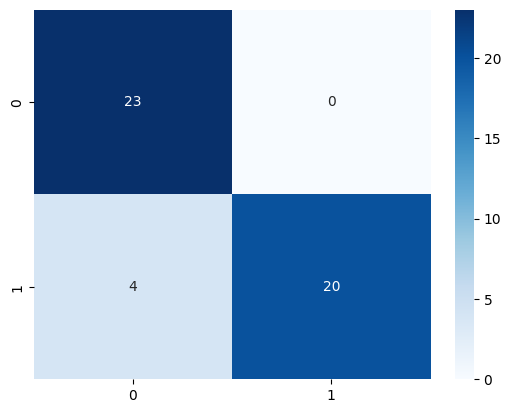

In [ ]:
##1st Model

import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

# Confusion Matrix

# Convert predictions to pandas DataFrame
y_true = rf_predictions.select("isFraud").toPandas()
y_pred = rf_predictions.select("prediction").toPandas()

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

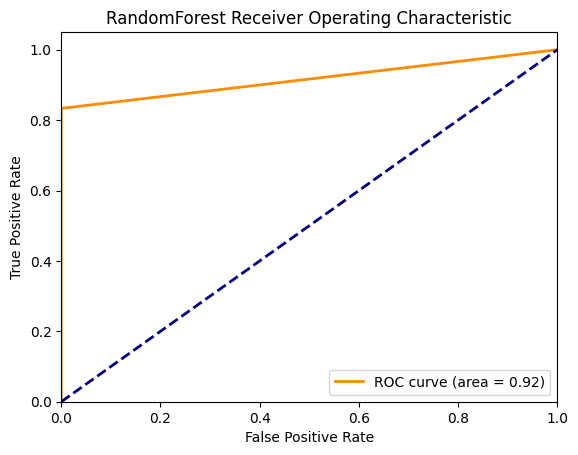

In [ ]:
# ROC Curve

fpr, tpr, _ = roc_curve(y_true, y_pred)
# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForest Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The Precision-Recall (PR) curve is a tool used in machine learning to visualize the trade-off between precision and recall for different threshold values1. It is particularly useful in scenarios where there is a large skew in the class distribution, such as credit card fraud detection2.

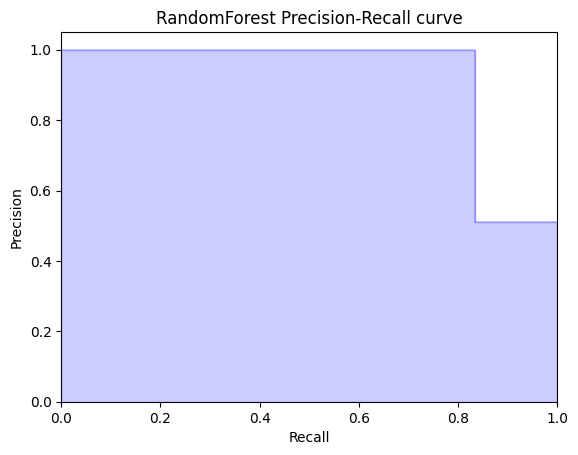

In [ ]:
# Precision-Recall Curve

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

# Plot precision-recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('RandomForest Precision-Recall curve')
plt.show()

Here’s what each term means:

True Positives (TP): These are the cases in which we predicted fraud (positive), and the real was also fraud (positive).
True Negatives (TN): We expected not fraud (negative), and the real was also not fraud (negative).
False Positives (FP): We expected fraud (positive), but the real was not fraud (negative). This is also known as a “Type I error.”
False Negatives (FN): We expected not fraud (negative), but the real was fraud (positive). This is also known as a “Type II error.”


<Axes: >

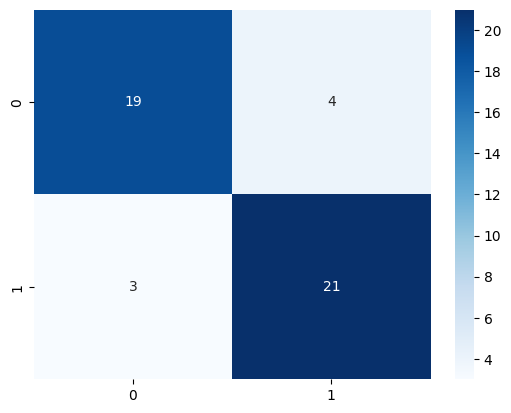

In [ ]:
##2nd Model
# Confusion Matrix

# Convert predictions to pandas DataFrame
y_true = log_reg_predictions.select("isFraud").toPandas()
y_pred = log_reg_predictions.select("prediction").toPandas()

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

The Receiver Operating Characteristic (ROC) curve is a useful tool used in the area of credit card fraud detection. It shows the True Positive Rate (TPR) against the False Positive Rate (FPR) for all different classification thresholds. This helps us to measure the performance of a fraud detection system over a range of decision thresholds.
In the setting of credit card fraud detection, the ROC curve helps in assessing the trade-off between properly spotting fraudulent transactions (TPR or recall) and incorrectly flagging genuine transactions as fraudulent (FPR)1. The area under the ROC curve (known as AUC ROC) is a widely used measure to assess the success of fraud detection systems.


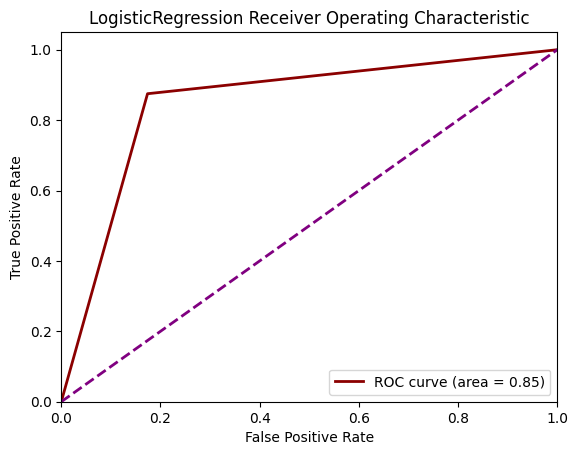

In [ ]:
# ROC Curve

fpr, tpr, _ = roc_curve(y_true, y_pred)
# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkred', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='purple', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LogisticRegression Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In the case of credit card fraud detection, the PR curve helps in assessing the trade-off between correctly detecting fraudulent transactions (precision) and the ability of the model to spot all fraudulent transactions (recall). The area under the PR curve (AUPRC) is a widely used metric to rate the success of fraud detection systems.

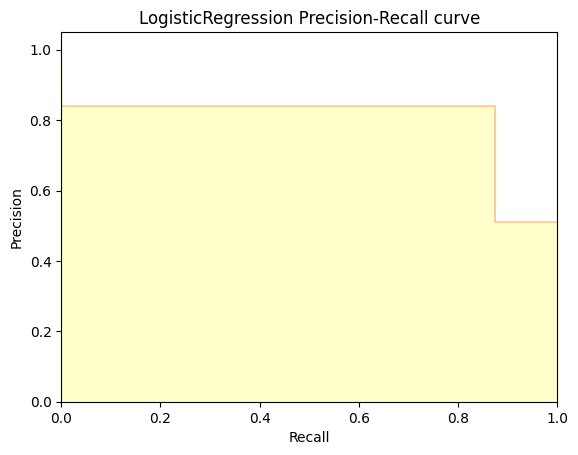

In [ ]:
# Precision-Recall Curve

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

# Plot precision-recall curve
plt.figure()
plt.step(recall, precision, color='r', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='yellow')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('LogisticRegression Precision-Recall curve')
plt.show()

<Axes: >

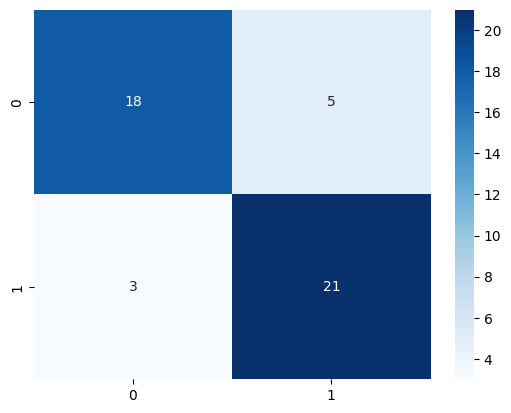

In [ ]:
##3rd Model
# Confusion Matrix

# Convert predictions to pandas DataFrame
y_true = svm_predictions.select("isFraud").toPandas()
y_pred = svm_predictions.select("prediction").toPandas()

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

A high AUC ROC number shows that the model has a high measure of separability, meaning it is capable of distinguishing between fraudulent and non-fraudulent transactions successfully. For instance, a credit card scam detection model with an AUC of 0.99 would be called highly effective.

However, it’s important to note that while the ROC curve and AUC ROC are normal tools for estimating the performance of fraud detection systems, they may not always be the best choice, especially in situations of class imbalance, such as fraud detection. Other measures like the Precision-Recall (PR) curve and the Average Precision (AP) might be more suited for such problems.


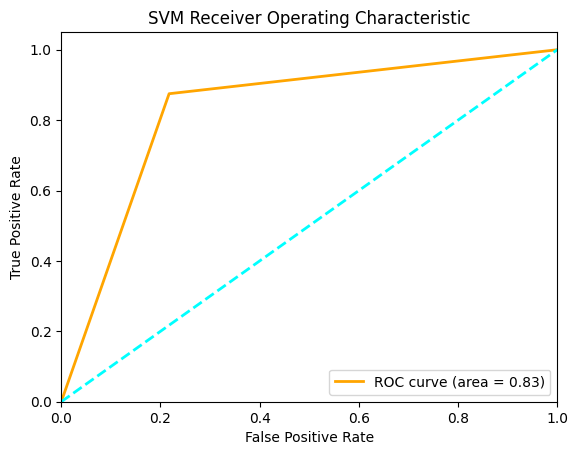

In [ ]:
# ROC Curve

fpr, tpr, _ = roc_curve(y_true, y_pred)
# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='cyan', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

A high AUPRC value shows that the model has a high measure of separability, meaning it is capable of distinguishing between fraudulent and non-fraudulent transactions successfully. For instance, a credit card theft detection model with an AUPRC of 0.82 would be called highly effective.

However, it’s important to note that while the PR curve and AUPRC are standard tools for measuring the performance of fraud detection systems, they may not always be the best choice, especially in situations of class imbalance, such as fraud detection. Other measures like the Receiver Operating Characteristic (ROC) curve and the Area Under the ROC curve (AUROC) might also be considered.


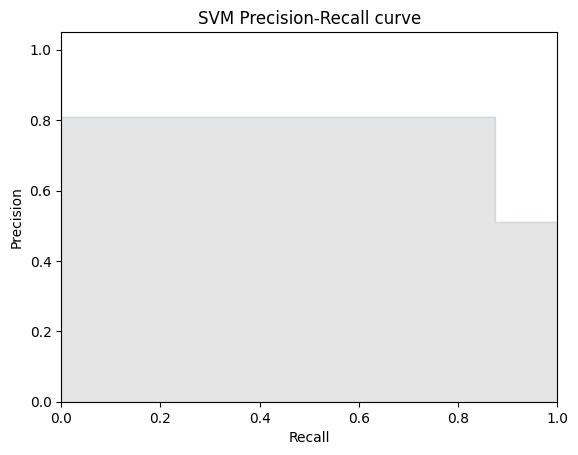

In [ ]:
# Precision-Recall Curve

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

# Plot precision-recall curve
plt.figure()
plt.step(recall, precision, color='lightblue', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='grey')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('SVM Precision-Recall curve')
plt.show()

---
# **LSEP Considerations**
---


#**Legal**

In our Credit Card Fraud Detection project, we have strictly adhered to legal and regulatory guidelines, ensuring the responsible use of financial data. By implementing rigorous data cleaning, feature engineering, and data preprocessing techniques, we maintain the integrity of the information used in our models. Our project complies with relevant data protection and privacy laws. This commitment to legal compliance is a critical aspect of our project, demonstrating our responsibility and respect for user privacy and data security.

#            **Social**
Our Credit Card Fraud Detection project has significant social implications, as understanding and mitigating fraudulent activities can positively impact consumer trust and financial security. By utilizing advanced techniques like single vectorization, scalarvector, and various machine learning algorithms, we contribute to a safer digital financial landscape. This project fosters a broader discussion on the role of AI and data analysis in promoting social welfare and financial literacy. By sharing our findings and methodologies, we encourage other researchers and practitioners to join the conversation and explore new ways to leverage data-driven insights for social good.


# **Ethical**

Ethical considerations are at the forefront of our Credit Card Fraud Detection project. We recognize the potential for misuse of financial data and have taken measures to ensure the responsible use of information. By implementing robust security protocols and transparent reporting mechanisms, we promote ethical data handling and analysis. Our project emphasizes the importance of fairness, accountability, and transparency in AI-driven decision-making, ensuring that our fraud detection models do not perpetuate existing biases or discrimination. This ethical commitment is essential to building trust with users and stakeholders and fostering responsible innovation in the financial technology sector.


# **Professional**

Our Credit Card Fraud Detection project reflects our professional dedication to data analysis and machine learning. By leveraging PySpark, we demonstrate our expertise in cutting-edge technologies and our commitment to staying at the forefront of our field. Our project highlights the importance of thorough evaluation, parameter tuning, and model building, showcasing our proficiency in data-driven problem-solving. Furthermore, our adherence to legal and ethical guidelines, clear communication of findings, and attention to system health demonstrate our professional responsibility and commitment to excellence in data analysis.

---

# **Convert ipynb to HTML**

---



In [ ]:
# install nbconvert (if facing the conversion error)
!pip3 install nbconvert

In [ ]:
# convert ipynb to html and submit this HTML file
!jupyter nbconvert --to html Your_Group_ID_CRWK_CN7030.ipynb

from nbconvert import HTMLExporter
import nbformat


notebook_filename = '/content/drive/MyDrive/big_data/GROUP[8]_CN7030.ipynb'

# Read the notebook
with open(notebook_filename, 'r', encoding='utf-8') as notebook_file:
    notebook_content = notebook_file.read()

# Convert notebook to HTML
notebook = nbformat.reads(notebook_content, as_version=4)
html_exporter = HTMLExporter()
(body, resources) = html_exporter.from_notebook_node(notebook)

# Save the HTML content to a file
html_filename = notebook_filename.replace('.ipynb', '.html')
with open(html_filename, 'w', encoding='utf-8') as html_file:
    html_file.write(body)


[NbConvertApp] WARNING | pattern 'Your_Group_ID_CRWK_CN7030.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]